<a href="https://colab.research.google.com/github/milkywaypeko/ASD_FI_Correlation/blob/main/ASD_FI_Correlation_Google.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Find Correlation between ASD Registration and Financial Independence

---

## 1. Import Library

In [1]:
import numpy as np # For Array, 
import pandas as pd # For Data
import matplotlib.pyplot as plt # For Graph
import seaborn as sns # For Pretty Graph
import statsmodels.api as sm # For LinearRegression
import statsmodels.formula.api as smf # For LinearRegression
from sklearn.preprocessing import PolynomialFeatures # For data power
from sklearn.model_selection import train_test_split # For resampling
from sklearn.linear_model import LinearRegression # For LinearRegression
from sklearn.metrics import mean_squared_error # For MSE
from sklearn.model_selection import LeaveOneOut # For LOOCV
from sklearn.model_selection import cross_val_score # For Cross Test
from sklearn.model_selection import KFold # For K-Fold
from sklearn.utils import resample # For resampling
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score #MSE, R2, ExVar error

## 2. Import Statistics

### 1) Define Name List

In [2]:
regionDic = {'Seoul':'서울특별시', 'Busan' : '부산광역시', 'Daegu' : '대구광역시', 'Incheon' : '인천광역시', 'Gwangju' : '광주광역시',
             'Daejeon' : '대전광역시', 'Ulsan' : '울산광역시', 'Sejong' : '세종특별자치시', 'Gyeonggi-do' : '경기도',
             'Gangwon-do' : '강원도', 'Chungcheongbuk-do' : '충청북도', 'Chungcheongnam-do' : '충청남도',
             'Jeollabuk-do' : '전라북도', 'Jeollanam-do' : '전라남도',
             'Gyeongsangbuk-do' : '경상북도', 'Gyeongsangnam-do' : '경상남도', 'Jeju' : '제주특별자치도'}

In [3]:
disabilityDic = {'지체' : 'PD', '뇌병변' : 'BL', '시각' : 'VD', '청각' : 'HD', '언어' : 'LD', '지적장애' : 'ID', '자폐성' : 'ASD',
                 '정신장애' : 'MD', '신장장애' : 'KD', '심장장애' : 'CD', '호흡기' : 'RD', '간' : 'HDB', '안면' : 'FD',
                 '장루요루' : 'IUF', '뇌전증' : 'EP', '발달장애' : 'DD'}

### 2)Import CSV

#### (1) Disabled Population 

In [4]:
disabledPopulation = {}
for EnglishName, KoreanName in regionDic.items():
    disabledPopulation[EnglishName] = pd.read_csv('https://raw.githubusercontent.com/milkywaypeko/ASD_FI_Correlation/main/Statistics/Disabled/Population%20of%20the%20disabled%20in%20{name}.csv'.format(name=EnglishName))
    #Label Disabled Population Statistics
    disabledPopulation[EnglishName].insert(0, '광역자치단체', KoreanName)

#### (2) Population Statistics

In [5]:
populationDic = {}
for EnglishName, KoreanName in regionDic.items():
    populationDic[EnglishName] = pd.read_csv('https://raw.githubusercontent.com/milkywaypeko/ASD_FI_Correlation/main/Statistics/Population/Resident%20population%20of%20{name}.csv'.format(name=EnglishName))
    #Label Population Statistics
    populationDic[EnglishName].insert(0, '광역자치단체', KoreanName)

#### (3) Financial independence Statistics

In [6]:
financial_Independence = {}
for EnglishName, KoreanName in regionDic.items():
    financial_Independence[EnglishName] = pd.read_csv('https://raw.githubusercontent.com/milkywaypeko/ASD_FI_Correlation/main/Statistics/Finance/Financial%20Independence%20of%20{name}.csv'.format(name=EnglishName))
    #Label Population Statistics
    financial_Independence[EnglishName].insert(0, '광역자치단체', KoreanName)

### 3) Connect And Merge Statistics

In [7]:
#Connect Disabled Population Statistics
dataD = pd.concat(disabledPopulation, ignore_index=True)

#Make Statistics For Developmental Disability
dataD['발달장애'] = dataD['지적장애'] + dataD['자폐성']

#Connect Population Statistics
dataP = pd.concat(populationDic, ignore_index=True)

#Connect Finance Statistics
dataF = pd.concat(financial_Independence, ignore_index=True)

In [8]:
#Merge All Statistics
temp = pd.merge(dataD, dataP)
data = pd.merge(temp, dataF)

### 4) rearrange data

In [9]:
#For label in english
data.rename(columns = {'광역자치단체' : 'RLG', '기초자치단체' : 'BLG', '인구' : 'Population',
                       '재정자립도 (%)' : 'Financial_Independence', '재정자주도 (%)' : 'Financial_often'}, inplace = True)
data.rename(columns = disabilityDic, inplace = True)

In [10]:
#Make Rate of All Disability
for KoreanName, EnglishName in disabilityDic.items():
    data['{name}_rate'.format(name=EnglishName)] = data[EnglishName] / data['Population']

#Make Rate of Developmental Disability
data['DD_rate'] = data['DD'] / data['Population']

#Make Rate of Developmental Disability of Autistic Spectrum Disorder
data['DD_ASD_rate'] = data['ASD'] / data['DD']

#Show Data
data

,RLG,BLG,PD,BL,VD,HD,LD,ID,ASD,MD,...,MD_rate,KD_rate,CD_rate,RD_rate,HDB_rate,FD_rate,IUF_rate,EP_rate,DD_rate,DD_ASD_rate
0,서울특별시,종로구,2661,574,717,905,42,396,111,271,...,0.001674,0.001551,0.000068,0.000142,0.000284,0.000037,0.000210,0.000124,0.003132,0.218935
1,서울특별시,중구,2613,568,735,809,33,304,67,220,...,0.001612,0.001656,0.000095,0.000198,0.000249,0.000037,0.000264,0.000161,0.002718,0.180593
2,서울특별시,용산구,3518,804,991,1144,66,530,106,298,...,0.001215,0.001399,0.000090,0.000179,0.000265,0.000024,0.000277,0.000082,0.002594,0.166667
3,서울특별시,성동구,5460,1219,1193,1581,104,710,174,436,...,0.001411,0.001495,0.000120,0.000304,0.000249,0.000049,0.000275,0.000126,0.002861,0.196833
4,서울특별시,광진구,5800,1252,1337,1656,94,818,167,521,...,0.001420,0.001602,0.000101,0.000172,0.000185,0.000022,0.000286,0.000134,0.002684,0.169543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,경상남도,산청군,1724,292,544,36,329,322,19,146,...,0.004121,0.002625,0.000028,0.000423,0.000452,0.000085,0.000536,0.000198,0.009625,0.055718
223,경상남도,함양군,1811,335,658,34,290,250,16,253,...,0.006404,0.002050,0.000101,0.000253,0.000405,0.000025,0.000557,0.000101,0.006733,0.060150
224,경상남도,거창군,2535,431,788,28,419,382,26,207,...,0.003338,0.002613,0.000065,0.000306,0.000339,0.000016,0.000387,0.000081,0.006580,0.063725
225,경상남도,합천군,2172,409,988,31,400,382,14,239,...,0.005361,0.002265,0.000224,0.000381,0.000314,0.000157,0.000673,0.000224,0.008883,0.035354


## 3. Correlation between ASD and Financial Independence

In [11]:
#Linear regression (X=Financial_Independence Y=ASD_rate) with statsmodels.formula.api of statsmodels
ASD_rate_ols_smf = smf.ols(formula='ASD_rate ~ Financial_Independence', data=data)

ASD_rate_ols_smf_results = ASD_rate_ols_smf.fit()
ASD_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.83e-09
Time:                        10:06:44   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0004   1.95e-05     19.406      0.000       0.000       0.000
Financial_Independence  4.873e-06      8e-07      6.090      0.000     3.3e-06    6.45e-06
==============================================================================
Omnibus:                       10.682   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.519
Skew:                           0.437   Prob(JB):                      0.00315
Kurtosis:                       3.673   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

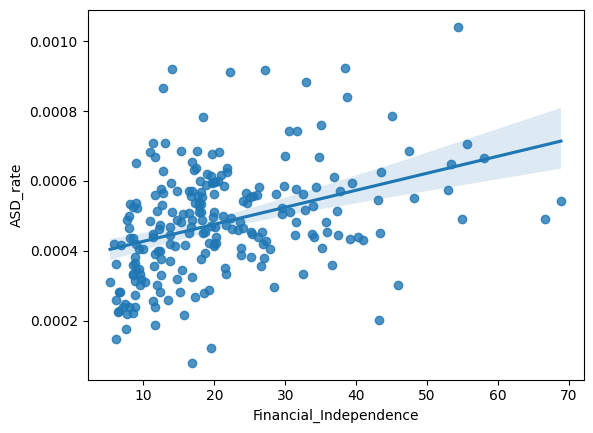

In [12]:
#Draw a graph (X=Financial_Independence Y=ASD_rate) with seaborn
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data)
plt.show()

# For Additional Infomation

---

## 1. Linear regression (X=Financial_Independence Y=ID_rate) with statsmodels.formula.api of statsmodels

In [13]:
ID_rate_ols_smf = smf.ols(formula='ID_rate ~ Financial_Independence', data=data)

ID_rate_ols_smf_results = ID_rate_ols_smf.fit()
ID_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                ID_rate   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     133.8
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.35e-24
Time:                        10:06:45   Log-Likelihood:                 1092.3
No. Observations:                 227   AIC:                            -2181.
Df Residuals:                     225   BIC:                            -2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0082      0.000     31.273      0.000       0.008       0.009
Financial_Independence    -0.0001   1.08e-05    -11.569      0.000      -0.000      -0.000
==============================================================================
Omnibus:                        6.805   Durbin-Watson:                   0.988
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.962
Skew:                           0.406   Prob(JB):                       0.0308
Kurtosis:                       2.723   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

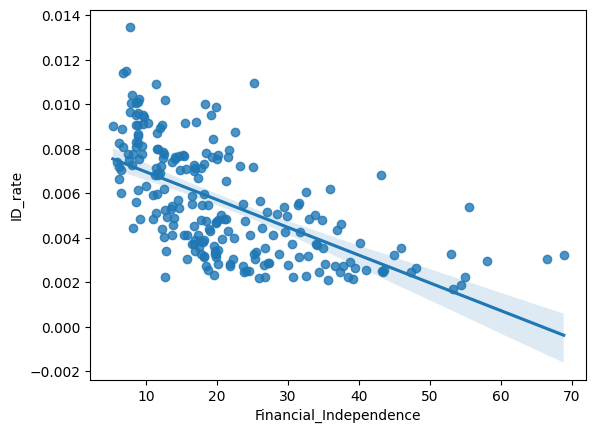

In [14]:
#Draw a graph (X=Financial_Independence Y=ID_rate) with seaborn
sns.regplot(x='Financial_Independence', y='ID_rate', data=data)
plt.show()

## 2. Linear regression (X=Financial_Independence Y=DD_rate) with statsmodels.formula.api of statsmodels

In [15]:
DD_rate_ols_smf = smf.ols(formula='DD_rate ~ Financial_Independence', data=data)

DD_rate_ols_smf_results = DD_rate_ols_smf.fit()
DD_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                DD_rate   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     129.2
Date:                Sun, 21 May 2023   Prob (F-statistic):           5.85e-24
Time:                        10:06:47   Log-Likelihood:                 1097.4
No. Observations:                 227   AIC:                            -2191.
Df Residuals:                     225   BIC:                            -2184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0086      0.000     33.457      0.000       0.008       0.009
Financial_Independence    -0.0001   1.05e-05    -11.368      0.000      -0.000   -9.89e-05
==============================================================================
Omnibus:                        7.530   Durbin-Watson:                   1.016
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                7.783
Skew:                           0.435   Prob(JB):                       0.0204
Kurtosis:                       2.741   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

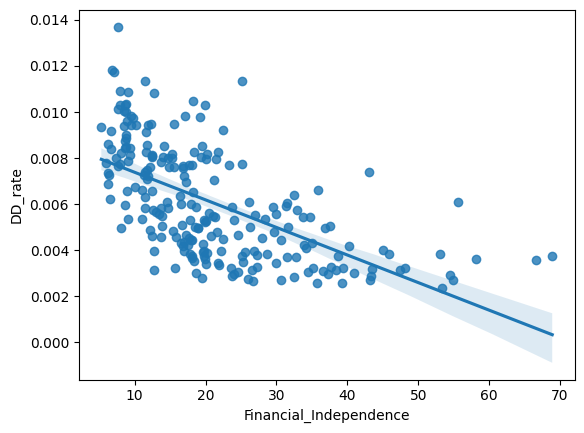

In [16]:
#Draw a graph (X=Financial_Independence Y=DD_rate) with seaborn
sns.regplot(x='Financial_Independence', y='DD_rate', data=data)
plt.show()

## 3. Linear regression (X=Financial_Independence Y=DD_ASD_rate) with statsmodels.formula.api of statsmodels

In [17]:
DD_ASD_rate_ols_smf = smf.ols(formula='DD_ASD_rate ~ Financial_Independence', data=data)

DD_ASD_rate_ols_smf_results = DD_ASD_rate_ols_smf.fit()
DD_ASD_rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            DD_ASD_rate   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     133.6
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.44e-24
Time:                        10:06:48   Log-Likelihood:                 372.19
No. Observations:                 227   AIC:                            -740.4
Df Residuals:                     225   BIC:                            -733.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0358      0.006      5.719      0.000       0.023       0.048
Financial_Independence     0.0030      0.000     11.560      0.000       0.002       0.003
==============================================================================
Omnibus:                       34.191   Durbin-Watson:                   0.953
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.355
Skew:                           0.859   Prob(JB):                     2.59e-12
Kurtosis:                       4.641   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

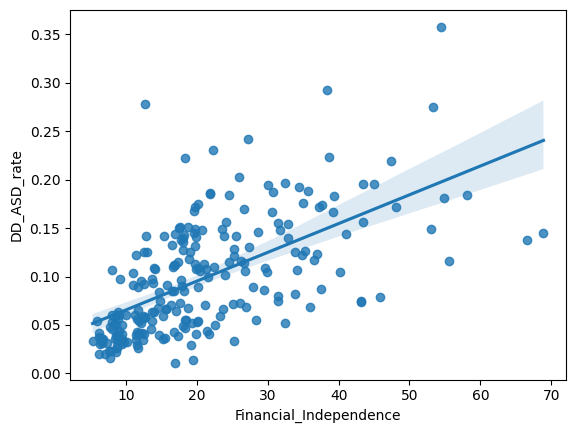

In [18]:
#Draw a graph (X=Financial_Independence Y=DD_ASD_rate) with seaborn
sns.regplot(x='Financial_Independence', y='DD_ASD_rate', data=data)
plt.show()

## 4. Linear regression (X=Financial_Independence Y=All Disability VS ASD with statsmodels.formula.api of statsmodels)

In [19]:
data['All_Disability'] = data.loc[:, 'PD' : 'EP'].sum(axis=1)

data['ASD_All_Disability_rate'] = data['ASD']/data['All_Disability']
    
ASD_VS_Disability_Rate_ols_smf = smf.ols(formula='ASD_All_Disability_rate ~ Financial_Independence'.format(name=EnglishName), data=data)
ASD_VS_Disability_Rate_ols_smf_results = ASD_VS_Disability_Rate_ols_smf.fit()

ASD_VS_Disability_Rate_ols_smf_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                              
===================================================================================
Dep. Variable:     ASD_All_Disability_rate   R-squared:                       0.370
Model:                                 OLS   Adj. R-squared:                  0.368
Method:                      Least Squares   F-statistic:                     132.4
Date:                     Sun, 21 May 2023   Prob (F-statistic):           2.12e-24
Time:                             10:06:50   Log-Likelihood:                 906.49
No. Observations:                      227   AIC:                            -1809.
Df Residuals:                          225   BIC:                            -1802.
Df Model:                                1                                         
Covariance Type:                 nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  0.0031      0.001      5.222      0.000       0.002       0.004
Financial_Independence     0.0003   2.44e-05     11.507      0.000       0.000       0.000
==============================================================================
Omnibus:                       77.615   Durbin-Watson:                   1.081
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.358
Skew:                           1.391   Prob(JB):                     4.38e-60
Kurtosis:                       7.600   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

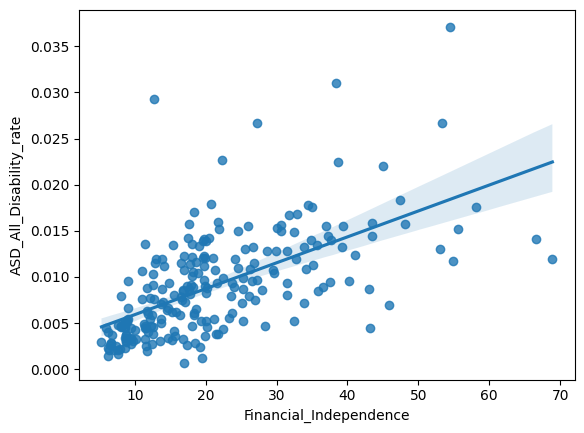

In [20]:
sns.regplot(x='Financial_Independence', y='ASD_All_Disability_rate', data=data)
plt.show()

## 5. Linear regression (X=Financial_Independence Y=All Disability with statsmodels.formula.api of statsmodels)

=================================== Correlation of  PD ===================================
                            OLS Regression Results                            
Dep. Variable:                PD_rate   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.443
Method:                 Least Squares   F-statistic:                     180.6
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.28e-30
Time:                        10:06:52   Log-Likelihood:                 739.33
No. Observations:                 227   AIC:                            -1475.
Df Residuals:                     225   BIC:                            -1468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
----------------------------

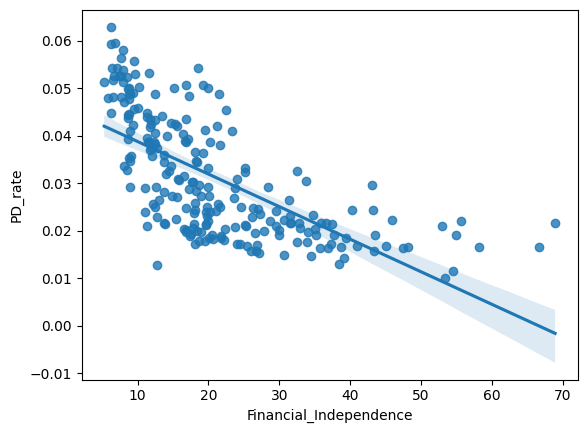


=================================== Correlation of  BL ===================================
                            OLS Regression Results                            
Dep. Variable:                BL_rate   R-squared:                       0.448
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     182.9
Date:                Sun, 21 May 2023   Prob (F-statistic):           6.76e-31
Time:                        10:06:53   Log-Likelihood:                 1202.4
No. Observations:                 227   AIC:                            -2401.
Df Residuals:                     225   BIC:                            -2394.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

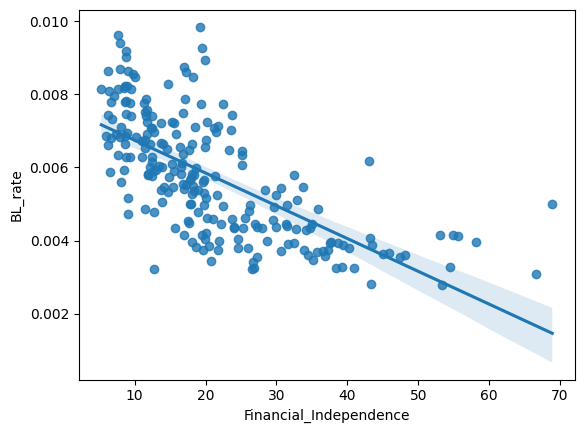


=================================== Correlation of  VD ===================================
                            OLS Regression Results                            
Dep. Variable:                VD_rate   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     112.9
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.22e-21
Time:                        10:06:54   Log-Likelihood:                 1059.8
No. Observations:                 227   AIC:                            -2116.
Df Residuals:                     225   BIC:                            -2109.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

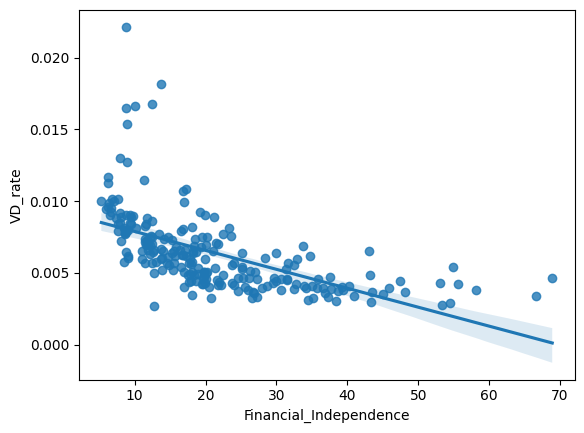


=================================== Correlation of  HD ===================================
                            OLS Regression Results                            
Dep. Variable:                HD_rate   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     47.30
Date:                Sun, 21 May 2023   Prob (F-statistic):           5.94e-11
Time:                        10:06:54   Log-Likelihood:                 861.36
No. Observations:                 227   AIC:                            -1719.
Df Residuals:                     225   BIC:                            -1712.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

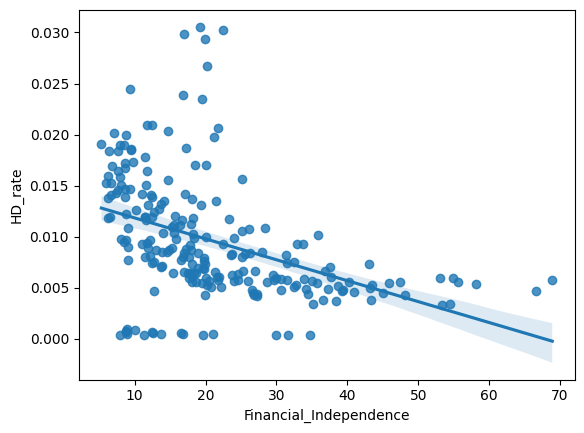


=================================== Correlation of  LD ===================================
                            OLS Regression Results                            
Dep. Variable:                LD_rate   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     11.25
Date:                Sun, 21 May 2023   Prob (F-statistic):           0.000935
Time:                        10:06:56   Log-Likelihood:                 1139.0
No. Observations:                 227   AIC:                            -2274.
Df Residuals:                     225   BIC:                            -2267.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

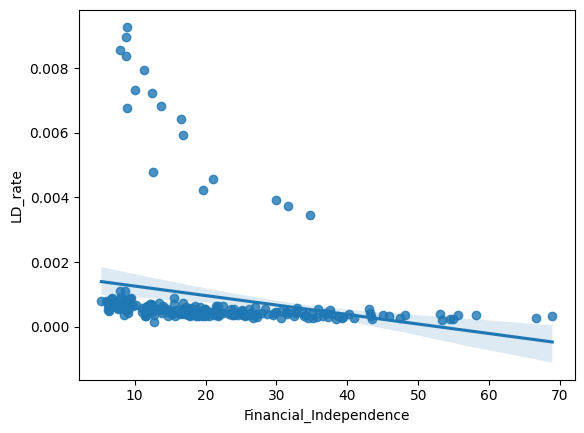


=================================== Correlation of  ID ===================================
                            OLS Regression Results                            
Dep. Variable:                ID_rate   R-squared:                       0.373
Model:                            OLS   Adj. R-squared:                  0.370
Method:                 Least Squares   F-statistic:                     133.8
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.35e-24
Time:                        10:06:57   Log-Likelihood:                 1092.3
No. Observations:                 227   AIC:                            -2181.
Df Residuals:                     225   BIC:                            -2174.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

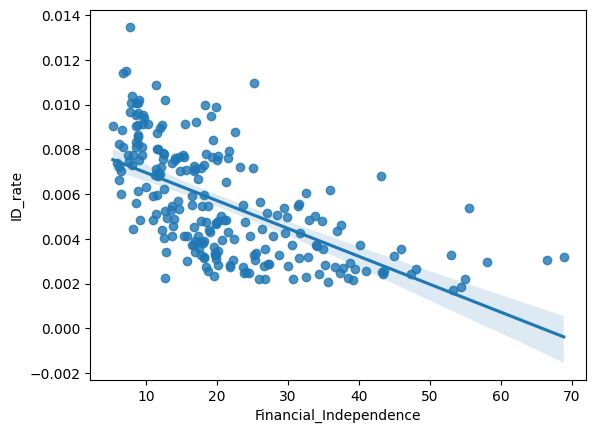


=================================== Correlation of  ASD ===================================
                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.83e-09
Time:                        10:06:57   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

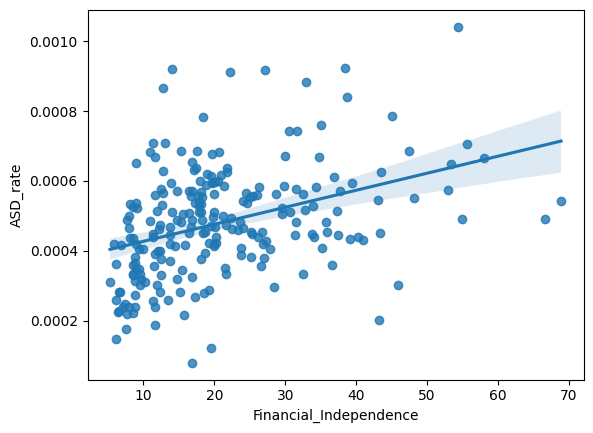


=================================== Correlation of  MD ===================================
                            OLS Regression Results                            
Dep. Variable:                MD_rate   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     98.48
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.75e-19
Time:                        10:06:58   Log-Likelihood:                 1228.6
No. Observations:                 227   AIC:                            -2453.
Df Residuals:                     225   BIC:                            -2446.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

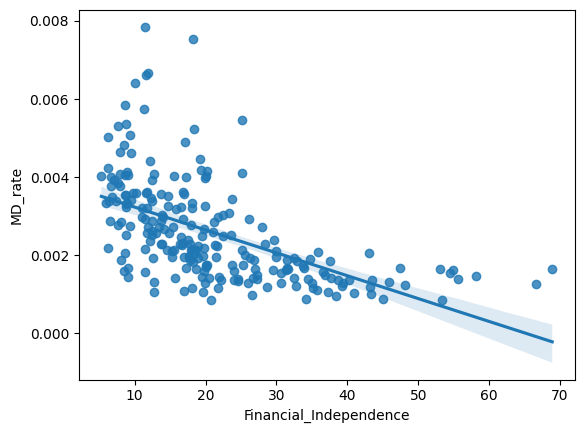


=================================== Correlation of  KD ===================================
                            OLS Regression Results                            
Dep. Variable:                KD_rate   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.142
Method:                 Least Squares   F-statistic:                     38.55
Date:                Sun, 21 May 2023   Prob (F-statistic):           2.55e-09
Time:                        10:06:59   Log-Likelihood:                 1481.1
No. Observations:                 227   AIC:                            -2958.
Df Residuals:                     225   BIC:                            -2951.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

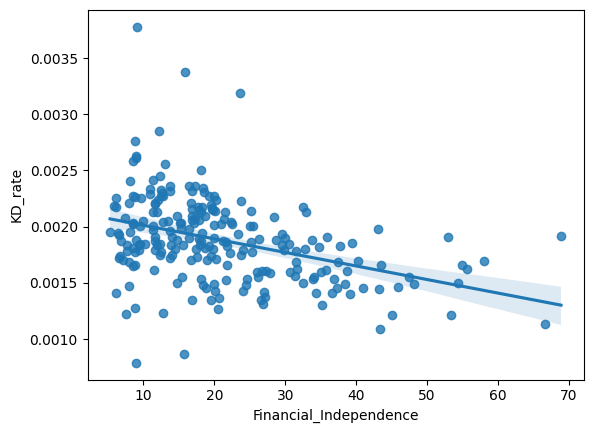


=================================== Correlation of  CD ===================================
                            OLS Regression Results                            
Dep. Variable:                CD_rate   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     6.625
Date:                Sun, 21 May 2023   Prob (F-statistic):             0.0107
Time:                        10:07:00   Log-Likelihood:                 1911.2
No. Observations:                 227   AIC:                            -3818.
Df Residuals:                     225   BIC:                            -3811.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

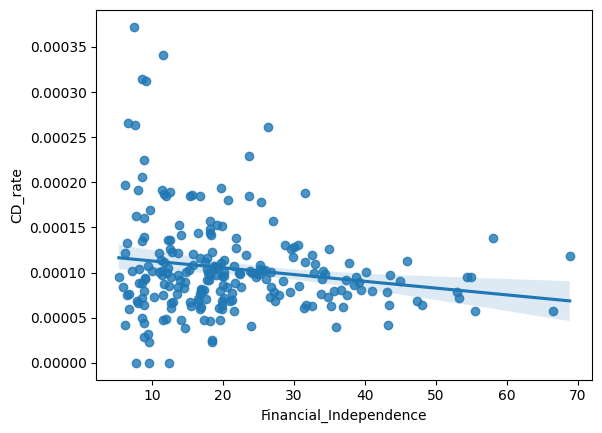


=================================== Correlation of  RD ===================================
                            OLS Regression Results                            
Dep. Variable:                RD_rate   R-squared:                       0.204
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     57.54
Date:                Sun, 21 May 2023   Prob (F-statistic):           8.67e-13
Time:                        10:07:01   Log-Likelihood:                 1738.1
No. Observations:                 227   AIC:                            -3472.
Df Residuals:                     225   BIC:                            -3465.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

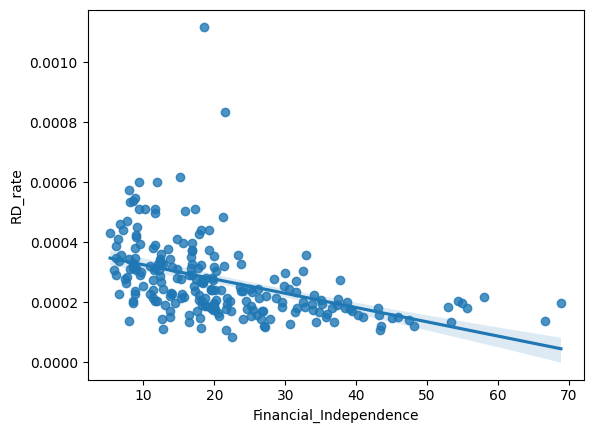


=================================== Correlation of  HDB ===================================
                            OLS Regression Results                            
Dep. Variable:               HDB_rate   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     23.26
Date:                Sun, 21 May 2023   Prob (F-statistic):           2.60e-06
Time:                        10:07:02   Log-Likelihood:                 1777.1
No. Observations:                 227   AIC:                            -3550.
Df Residuals:                     225   BIC:                            -3543.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

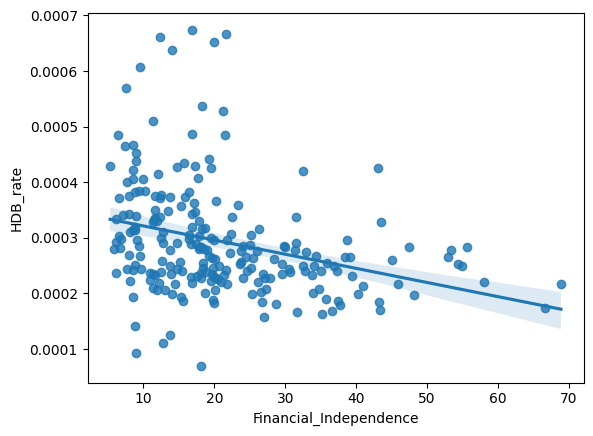


=================================== Correlation of  FD ===================================
                            OLS Regression Results                            
Dep. Variable:                FD_rate   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     18.12
Date:                Sun, 21 May 2023   Prob (F-statistic):           3.05e-05
Time:                        10:07:03   Log-Likelihood:                 2021.0
No. Observations:                 227   AIC:                            -4038.
Df Residuals:                     225   BIC:                            -4031.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

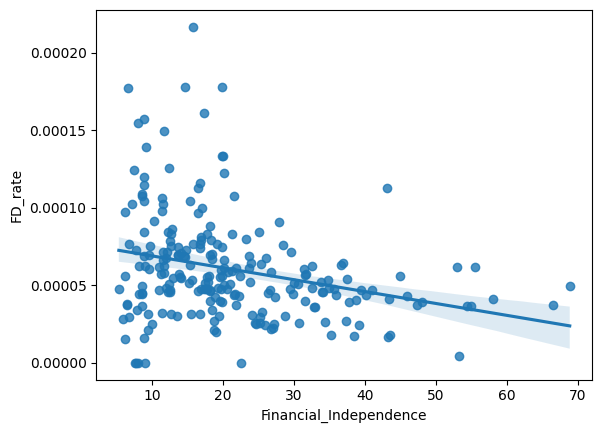


=================================== Correlation of  IUF ===================================
                            OLS Regression Results                            
Dep. Variable:               IUF_rate   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.312
Method:                 Least Squares   F-statistic:                     103.7
Date:                Sun, 21 May 2023   Prob (F-statistic):           2.85e-20
Time:                        10:07:05   Log-Likelihood:                 1723.5
No. Observations:                 227   AIC:                            -3443.
Df Residuals:                     225   BIC:                            -3436.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
--------------------------

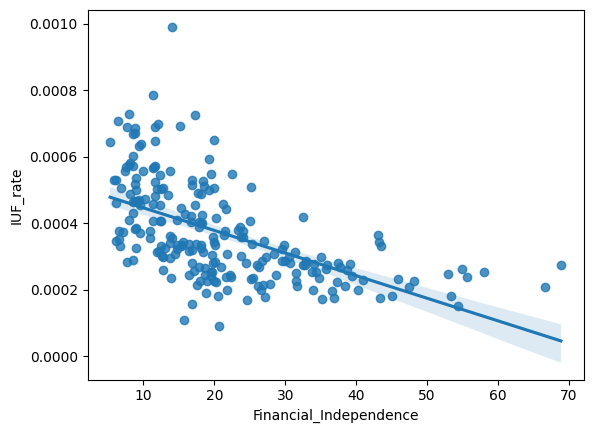


=================================== Correlation of  EP ===================================
                            OLS Regression Results                            
Dep. Variable:                EP_rate   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.230
Method:                 Least Squares   F-statistic:                     68.64
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.06e-14
Time:                        10:07:06   Log-Likelihood:                 1834.9
No. Observations:                 227   AIC:                            -3666.
Df Residuals:                     225   BIC:                            -3659.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

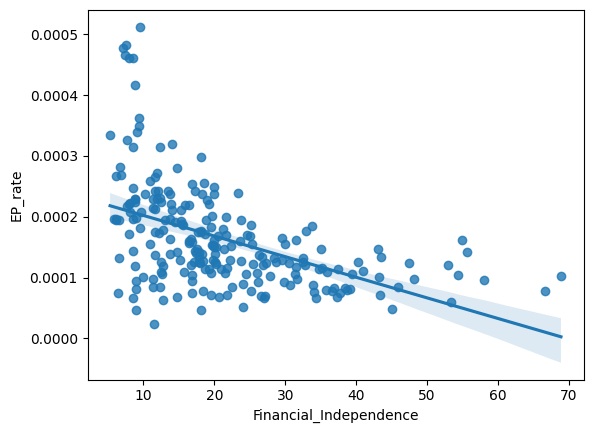


=================================== Correlation of  DD ===================================
                            OLS Regression Results                            
Dep. Variable:                DD_rate   R-squared:                       0.365
Model:                            OLS   Adj. R-squared:                  0.362
Method:                 Least Squares   F-statistic:                     129.2
Date:                Sun, 21 May 2023   Prob (F-statistic):           5.85e-24
Time:                        10:07:07   Log-Likelihood:                 1097.4
No. Observations:                 227   AIC:                            -2191.
Df Residuals:                     225   BIC:                            -2184.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
---------------------------

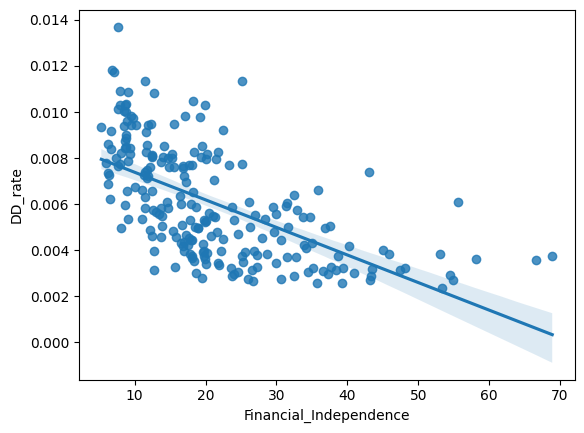

In [21]:
for KoreanName, EnglishName in disabilityDic.items():
    print('=================================== Correlation of ', EnglishName, '===================================')
    Disability_Rate_ols_smf = smf.ols(formula='{name}_rate ~ Financial_Independence'.format(name=EnglishName), data=data)
    Disability_Rate_ols_smf_results = Disability_Rate_ols_smf.fit()
    
    print(Disability_Rate_ols_smf_results.summary())
    
    sns.regplot(x='Financial_Independence', y='{name}_rate'.format(name=EnglishName), data=data)
    plt.show()
    print('')

# For Additional data analysis (For Computer Science)

---

## 1. Linear regression with sklearn

### 1) Linear regression (X=Financial_Independence Y=ASD_rate) with sklearn

In [22]:
ols_ASD_rate_skl = LinearRegression(fit_intercept=True)

ASD_rate_skl_X_train = data['Financial_Independence'].values.reshape(-1, 1)
ASD_rate_skl_y_true = data['ASD_rate']

ols_ASD_rate_skl.fit(ASD_rate_skl_X_train, ASD_rate_skl_y_true)
print('Intercept : ', ols_ASD_rate_skl.intercept_, 'Coef : ', ols_ASD_rate_skl.coef_)
ols_ASD_rate_skl_pre = ols_ASD_rate_skl.predict(data['Financial_Independence'].values.reshape(-1, 1))

ols_ASD_rate_skl_summary = { 'R2' : r2_score(ASD_rate_skl_y_true, ols_ASD_rate_skl_pre),
                  'Ex. Var' : explained_variance_score(ASD_rate_skl_y_true, ols_ASD_rate_skl_pre),
                  'MSE' : mean_squared_error(ASD_rate_skl_y_true, ols_ASD_rate_skl_pre)}

for k, v in ols_ASD_rate_skl_summary.items():
    print(k,':', v)

Intercept :  0.00037832802857155494 Coef :  [4.87333138e-06]
R2 : 0.1415222123800275
Ex. Var : 0.14152221238002738
MSE : 2.1384062195390713e-08


### 2) Draw a graph (X=Financial_Independence Y=ASD_rate) with matplotlib

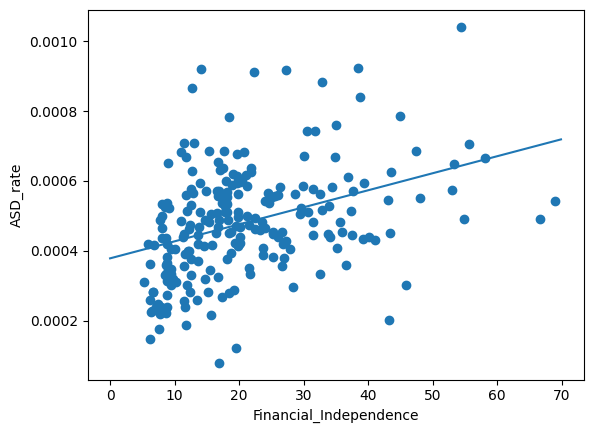

In [23]:
ols_ASD_rate_skl_x = np.arange(0, 70, 0.1)
ols_ASD_rate_skl_y = [ols_ASD_rate_skl.coef_*x + ols_ASD_rate_skl.intercept_ for x in ols_ASD_rate_skl_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(ols_ASD_rate_skl_x, ols_ASD_rate_skl_y)
plt.xlabel('Financial_Independence')
plt.ylabel('ASD_rate')
plt.show()

## 2. Linear regression with statsmodels

### 1) Linear regression (X=Financial_Independence Y=ASD_rate) with statsmodels..api of statsmodels

In [24]:
ASD_rate_sm_X_train = data['Financial_Independence']
ASD_rate_sm_y_true = data['ASD_rate']

ASD_rate_ols_sm = sm.OLS(ASD_rate_sm_y_true, sm.add_constant(ASD_rate_sm_X_train))

ASD_rate_ols_sm_results = ASD_rate_ols_sm.fit()
ASD_rate_ols_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.83e-09
Time:                        10:07:08   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0.0004   1.95e-05     19.406      0.000       0.000       0.000
Financial_Independence  4.873e-06      8e-07      6.090      0.000     3.3e-06    6.45e-06
==============================================================================
Omnibus:                       10.682   Durbin-Watson:                   1.342
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               11.519
Skew:                           0.437   Prob(JB):                      0.00315
Kurtosis:                       3.673   Cond. No.                         48.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 2)Draw a graph (X=Financial_Independence Y=ASD_rate) with matplotlib

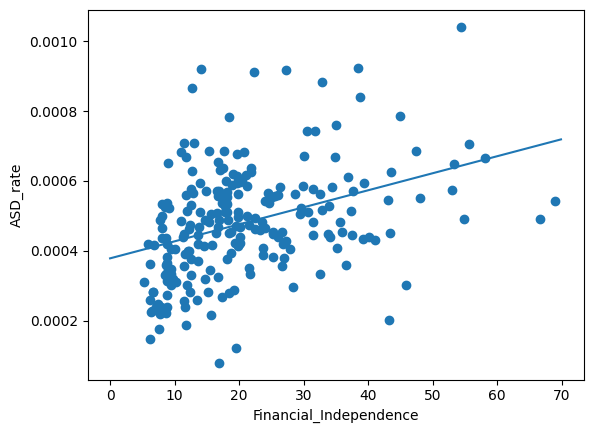

In [25]:
FI_OLS_x = np.arange(0, 70, 0.1)
FI_OLS_y = [ASD_rate_ols_sm_results.predict([1, x]) for x in FI_OLS_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(FI_OLS_x, FI_OLS_y)
plt.xlabel('Financial_Independence')
plt.ylabel('ASD_rate')
plt.show()

## 3. MSE resampling test

In [26]:
# Make Polynomial Maximum 20
Financial_Independence_pol = PolynomialFeatures(degree=30, interaction_only=False, include_bias=False) 

# polf[0] power 1, polf[1] power 2, polf[2] power 3, polf[3] power 4, polf[4] power 5...
Financial_Independence_polf = Financial_Independence_pol.fit_transform(data.loc[:, 'Financial_Independence'].values.reshape(-1, 1))

### 1) Resampling 50% degree 1 to 20

In [27]:
#For Resampling
X, y = Financial_Independence_polf, data.ASD_rate 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=10)

# ols model with intercept and Power
lm = [LinearRegression()]*20
for i in range(0, 20):
    lm[i] = LinearRegression(fit_intercept=True)

# Fitting
lm_fit = [LinearRegression()]*20
lm_fit[0] = lm[0].fit(X_train[ : ,0].reshape(-1, 1), y_train)
for i in range(1, 20):
    lm_fit[i] = lm[i].fit(X_train[ : ,0 : i+1], y_train)

# Predict
lm_predict = [np.ndarray(len(y_test))]*20
lm_predict[0] = lm_fit[0].predict(X_test[ : ,0].reshape(-1, 1))
for i in range(1, 20):
    lm_predict[i] = lm_fit[i].predict(X_test[ : , 0 : i + 1])
    
# Make MSE
lm_MSE = np.ndarray(20)
for i in range(0, 20):
    lm_MSE[i] = mean_squared_error(y_test, lm_predict[i])
    print('lm_MSE[{num}] : '.format(num=i), lm_MSE[i])

lm_MSE[0] :  2.472140177156666e-08
lm_MSE[1] :  2.403820230455493e-08
lm_MSE[2] :  2.3665596505195317e-08
lm_MSE[3] :  2.307415959093198e-08
lm_MSE[4] :  2.326225443017782e-08
lm_MSE[5] :  2.3415079839512562e-08
lm_MSE[6] :  3.230472410749018e-08
lm_MSE[7] :  1.297551075671432e-07
lm_MSE[8] :  1.3670338171046425e-07
lm_MSE[9] :  5.8932892710320275e-08
lm_MSE[10] :  2.2714400959408465e-07
lm_MSE[11] :  3.586604750001291e-06
lm_MSE[12] :  2.035679242838059e-05
lm_MSE[13] :  1.089479057420057e-06
lm_MSE[14] :  8.247445595504901e-08
lm_MSE[15] :  8.614556886245521e-07
lm_MSE[16] :  3.570308841034994e-06
lm_MSE[17] :  2.11831766829418e-06
lm_MSE[18] :  8.171763729582645e-06
lm_MSE[19] :  0.0002563324466980596


#### (1) Draw a graph (X=Power Y=MSE) with seaborn

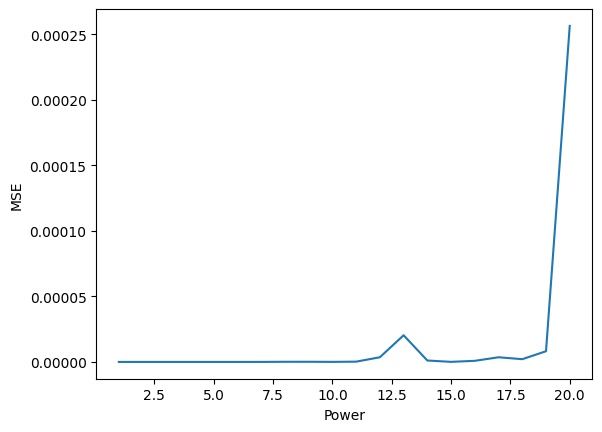

In [28]:
MSE_X = np.arange(1, 21)
MSE_y = lm_MSE
sns.lineplot(x = MSE_X, y = MSE_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 2) For LOOCV splits data

In [29]:
X, y = Financial_Independence_polf, data.ASD_rate 

loocv = LeaveOneOut()
loocv.get_n_splits(X)

227

In [30]:
#For LOOCV Make MSE
lm = [LinearRegression(fit_intercept=True)] * 20
lm_fit = [LinearRegression(fit_intercept=True)] * 20
lm_predict = [np.ndarray] * 20
loocvMSE = []
for i in np.arange(0, 20):
    loocv_mse = []
    for train_index, test_index in loocv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if(i==0):
            lm_fit[0] = lm[0].fit(X_train[ : ,0].reshape(-1, 1), y_train)
            lm_predict[0] = lm_fit[0].predict(X_test[ : ,0].reshape(-1, 1))
        else:
            lm_fit[i] = lm[i].fit(X_train[ : ,0 : i+1], y_train)
            lm_predict[i] = lm_fit[i].predict(X_test[ : ,0 : i+1])
        
        loocv_mse.append(mean_squared_error(y_test, lm_predict[i]))
    loocvMSE.append(np.array(loocv_mse).mean())
    print('lm[', str(i), '] MSE : ', loocvMSE[i])

lm[ 0 ] MSE :  2.1827010580636272e-08
lm[ 1 ] MSE :  2.1184676851991945e-08
lm[ 2 ] MSE :  2.126619024659133e-08
lm[ 3 ] MSE :  2.0587522333111203e-08
lm[ 4 ] MSE :  2.0810022374247614e-08
lm[ 5 ] MSE :  2.148145054772221e-08
lm[ 6 ] MSE :  2.2700299320295653e-08
lm[ 7 ] MSE :  2.119385732793295e-08
lm[ 8 ] MSE :  2.715403495706465e-08
lm[ 9 ] MSE :  7.763307839601185e-08
lm[ 10 ] MSE :  2.3416735202167276e-07
lm[ 11 ] MSE :  6.187939545518563e-07
lm[ 12 ] MSE :  1.3789680172513161e-06
lm[ 13 ] MSE :  2.1222284077782396e-07
lm[ 14 ] MSE :  8.982669895765869e-07
lm[ 15 ] MSE :  3.3661283951886266e-06
lm[ 16 ] MSE :  1.048971696558285e-05
lm[ 17 ] MSE :  2.779766580352999e-05
lm[ 18 ] MSE :  6.522420342661163e-05
lm[ 19 ] MSE :  0.00014091299674557256


#### (1) Draw a graph (X=Power Y=MSE) with seaborn

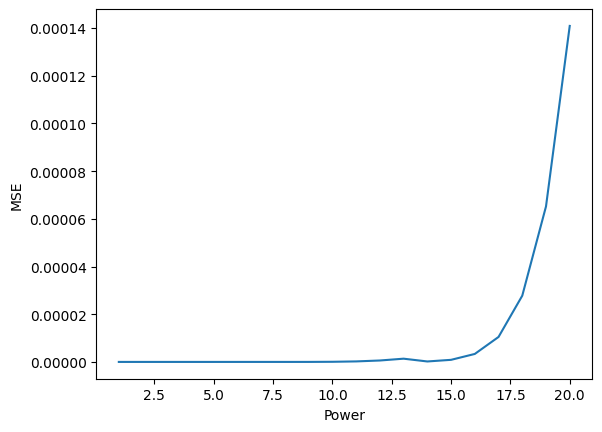

In [31]:
MSE_LOOCV_X = np.arange(1, 21)
MSE_LOOCV_y = np.array(loocvMSE)
sns.lineplot(x = MSE_LOOCV_X, y = MSE_LOOCV_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 3) For Cross Test LOOCV splits data

In [32]:
# For Cross Test LOOCV
lm = [LinearRegression(fit_intercept=True)]*20
scoreMSE = []

for i in np.arange(0, 20):
    if(i==0):
        cval = cross_val_score(lm[i],
                                    Financial_Independence_polf[:, 0].reshape(-1, 1),
                                    data.ASD_rate ,
                                    cv=len(data), # k=n k-Fold -> LOOCV
                                    n_jobs=-1,
                                    scoring='neg_mean_squared_error')
        scoreMSE.append(-cval.mean())
        
    else:
        cval = cross_val_score(lm[i],
                                    Financial_Independence_polf[:, 0 : i+1],
                                    data.ASD_rate ,
                                    cv=len(data), # k=n k-Fold -> LOOCV
                                    n_jobs=-1,
                                    scoring='neg_mean_squared_error')
        scoreMSE.append(-cval.mean())
    print('lm[', str(i), '] MSE : ', scoreMSE[i])

lm[ 0 ] MSE :  2.1827010580636272e-08
lm[ 1 ] MSE :  2.1184676851991945e-08
lm[ 2 ] MSE :  2.126619024659133e-08
lm[ 3 ] MSE :  2.0587522333111203e-08
lm[ 4 ] MSE :  2.0810022374247614e-08
lm[ 5 ] MSE :  2.148145054772221e-08
lm[ 6 ] MSE :  2.2700299320295653e-08
lm[ 7 ] MSE :  2.119385732793295e-08
lm[ 8 ] MSE :  2.715403495706465e-08
lm[ 9 ] MSE :  7.763307839601185e-08
lm[ 10 ] MSE :  2.3416735202167276e-07
lm[ 11 ] MSE :  6.187939545518563e-07
lm[ 12 ] MSE :  1.3789680172513161e-06
lm[ 13 ] MSE :  2.1222284077782396e-07
lm[ 14 ] MSE :  8.982669895765869e-07
lm[ 15 ] MSE :  3.3661283951886266e-06
lm[ 16 ] MSE :  1.048971696558285e-05
lm[ 17 ] MSE :  2.779766580352999e-05
lm[ 18 ] MSE :  6.522420342661163e-05
lm[ 19 ] MSE :  0.00014091299674557256


#### (1) Draw a graph (X=Power Y=MSE) with seaborn

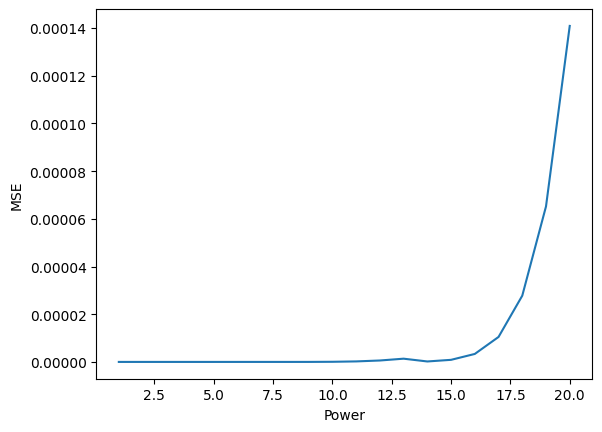

In [33]:
MSE_score_X = np.arange(1, 21)
MSE_score_y = np.array(scoreMSE)
sns.lineplot(x = MSE_score_X, y = MSE_score_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 4)For K-Fold Make MSE

In [34]:
#Load K-Fold Model
X, y = Financial_Independence_polf, data.ASD_rate 
kf = KFold(n_splits=10, shuffle=True, random_state=10)

lm1_MSE :  2.2004386628875764e-08
lm2_MSE :  2.124999211328784e-08
lm3_MSE :  2.1283436722240926e-08
lm4_MSE :  2.0755558603111968e-08
lm5_MSE :  2.0928434761912505e-08
lm6_MSE :  2.131062492459989e-08
lm7_MSE :  2.3308870559878844e-08
lm8_MSE :  2.1515928293361466e-08
lm9_MSE :  2.8123264407817186e-08
lm10_MSE :  6.748237022313999e-08
lm11_MSE :  2.1846756420982084e-07
lm12_MSE :  6.488076556357149e-07
lm13_MSE :  1.696949063313905e-06
lm14_MSE :  2.784843985449707e-07
lm15_MSE :  9.267527592230284e-07
lm16_MSE :  2.8303975834110925e-06
lm17_MSE :  7.586169465841526e-06
lm18_MSE :  1.839316677971731e-05
lm19_MSE :  4.230118755984703e-05
lm20_MSE :  9.52394274223927e-05


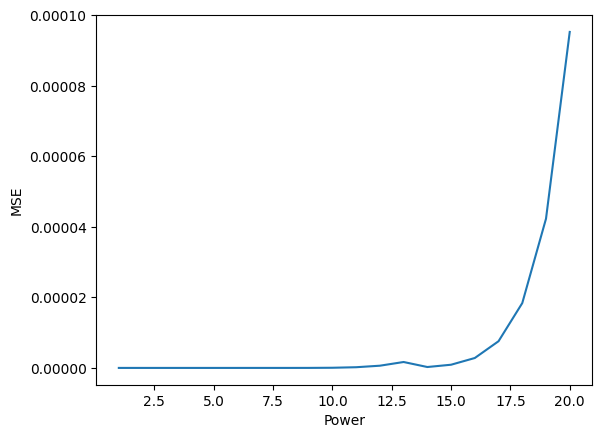

In [35]:
#For K-Fold Make MSE
kf_poly = []

for i in range(0, 20):
    kf_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        if i == 0:
            X_TRAIN = X_train[:, 0:1]
            X_TEST = X_test[:,0:1]
            
        else:
            X_TRAIN = X_train[:, 0:i+1]
            X_TEST = X_test[:,0:i+1]
        kf_mse.append(
            mean_squared_error(
                y_test,
                LinearRegression(fit_intercept=True)
                                 .fit(
                                     X_TRAIN,
                                     y_train
                                 )
                                 .predict(
                                     X_TEST
                                 )
                            )
                        )
    kf_poly.append(np.array(kf_mse).mean())
    print('lm' + str(i + 1) + '_MSE : ', kf_poly[i])

MSE_KFold_X = np.arange(1, 21)
MSE_KFold_y = np.array(kf_poly)
MSE_KFold_y
sns.lineplot(x = MSE_KFold_X, y = MSE_KFold_y) 
plt.xlabel('Power')
plt.ylabel('MSE')
plt.show()

### 5)Linear regression (X=Financial_Independence^4 Y=ASD_rate) with statsmodels..api of statsmodels

In [36]:
ASD_rate_4_X_train = Financial_Independence_polf[ : ,0 : 4]
ASD_rate_4_y_true = data['ASD_rate']

ASD_rate_4_ols_sm = sm.OLS(ASD_rate_4_y_true, sm.add_constant(ASD_rate_4_X_train))

ASD_rate_4_ols_sm_results = ASD_rate_4_ols_sm.fit()
ASD_rate_4_ols_sm_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               ASD_rate   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     14.67
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.20e-10
Time:                        10:07:47   Log-Likelihood:                 1691.7
No. Observations:                 227   AIC:                            -3373.
Df Residuals:                     222   BIC:                            -3356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.8e-05      0.000     -0.175      0.861      -0.000       0.000
x1          6.886e-05   1.78e-05      3.858      0.000    3.37e-05       0.000
x2          -3.21e-06   9.98e-07     -3.217      0.001   -5.18e-06   -1.24e-06
x3          6.328e-08   2.17e-08      2.922      0.004    2.06e-08    1.06e-07
x4         -4.297e-10   1.57e-10     -2.731      0.007    -7.4e-10    -1.2e-10
==============================================================================
Omnibus:                       13.284   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               17.531
Skew:                           0.423   Prob(JB):                     0.000156
Kurtosis:                       4.067   Cond. No.                     2.97e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.97e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### (1) Draw a graph (X=Financial_Independence^4 Y=ASD_rate) with matplotlib

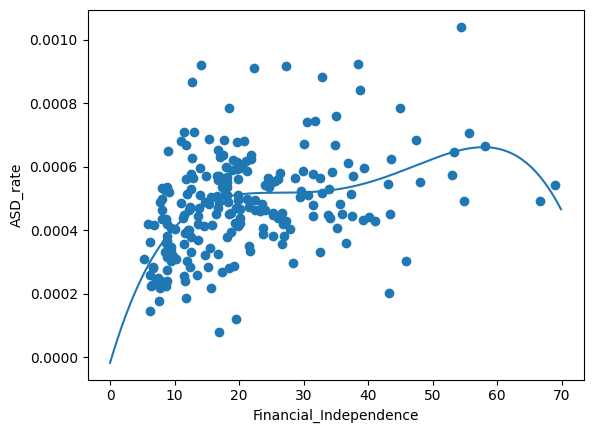

In [37]:
FI_OLS_4_x = np.arange(0, 70, 0.1)

FI_OLS_4_y = [ASD_rate_4_ols_sm_results.predict([np.power(x, i) for i in range(0, 5)]) for x in FI_OLS_4_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.plot(FI_OLS_4_x, FI_OLS_4_y)
plt.xlabel('Financial_Independence')
plt.ylabel('ASD_rate')
plt.show()

### (2) Draw a graph (X=Financial_Independence^4 Y=ASD_rate) with seaborn

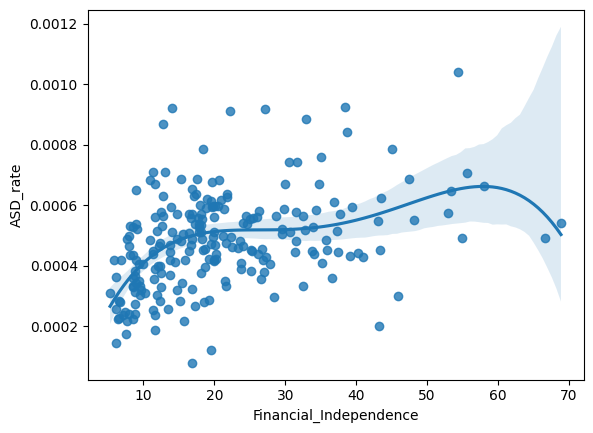

In [38]:
sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = 4)
plt.show()

##### This model Lower MSE but hard to interprint

### 6)Linear regression (X=Financial_Independence Y=ASD_rate) power with statsmodels..api of statsmodels

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.142
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     37.09
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.83e-09
Time:                        10:07:48   Log-Likelihood:                 1682.4
No. Observations:                 227   AIC:                            -3361.
Df Residuals:                     225   BIC:                            -3354.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   1.95e-05     19.406      0.0

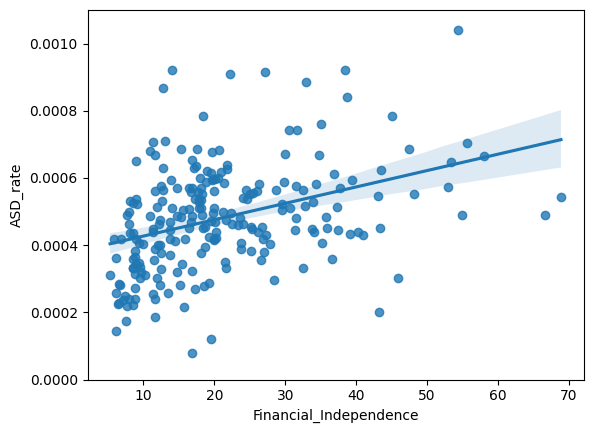

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.171
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     23.12
Date:                Sun, 21 May 2023   Prob (F-statistic):           7.44e-10
Time:                        10:07:48   Log-Likelihood:                 1686.4
No. Observations:                 227   AIC:                            -3367.
Df Residuals:                     224   BIC:                            -3356.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003   3.43e-05      8.684      0.0

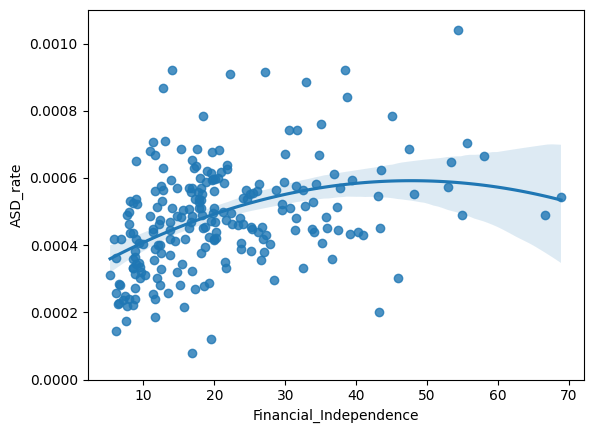

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     16.59
Date:                Sun, 21 May 2023   Prob (F-statistic):           9.16e-10
Time:                        10:07:49   Log-Likelihood:                 1687.9
No. Observations:                 227   AIC:                            -3368.
Df Residuals:                     223   BIC:                            -3354.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002   5.94e-05      3.578      0.0

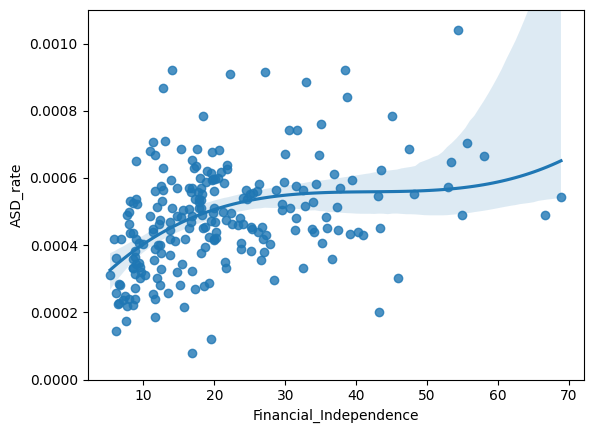

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     14.67
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.20e-10
Time:                        10:07:49   Log-Likelihood:                 1691.7
No. Observations:                 227   AIC:                            -3373.
Df Residuals:                     222   BIC:                            -3356.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -1.8e-05      0.000     -0.175      0.8

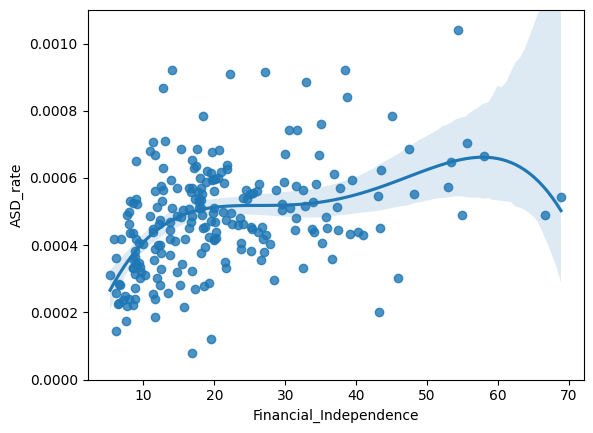

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.209
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     11.68
Date:                Sun, 21 May 2023   Prob (F-statistic):           4.96e-10
Time:                        10:07:50   Log-Likelihood:                 1691.7
No. Observations:                 227   AIC:                            -3371.
Df Residuals:                     221   BIC:                            -3351.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.602e-05      0.000     -0.184      0.8

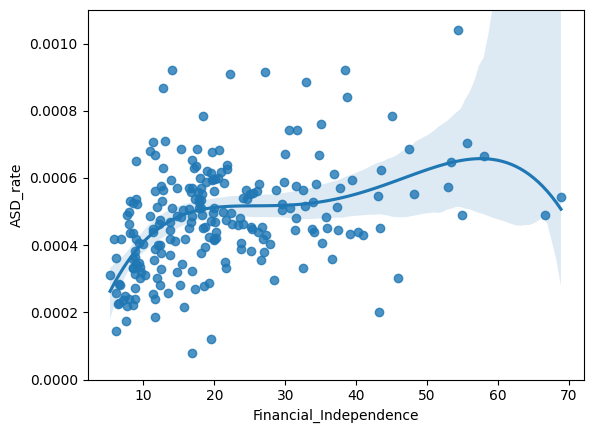

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     9.875
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.21e-09
Time:                        10:07:50   Log-Likelihood:                 1692.1
No. Observations:                 227   AIC:                            -3370.
Df Residuals:                     220   BIC:                            -3346.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.000     -0.874      0.3

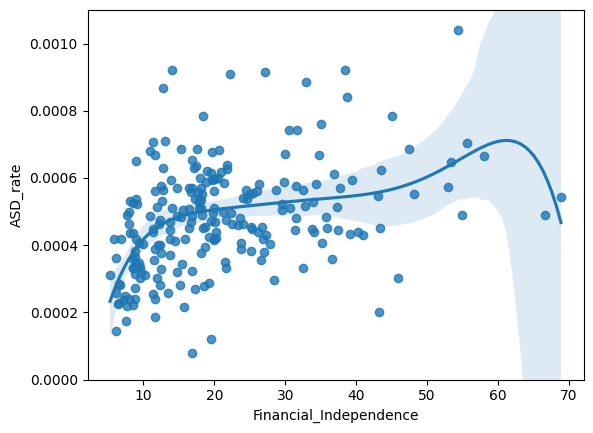

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     8.473
Date:                Sun, 21 May 2023   Prob (F-statistic):           3.59e-09
Time:                        10:07:51   Log-Likelihood:                 1692.3
No. Observations:                 227   AIC:                            -3369.
Df Residuals:                     219   BIC:                            -3341.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.001     -0.929      0.3

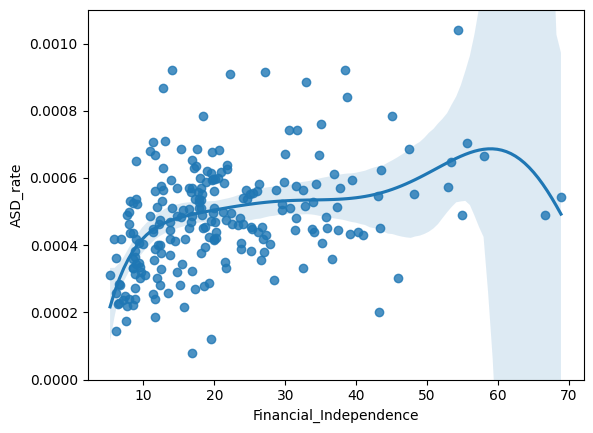

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     8.820
Date:                Sun, 21 May 2023   Prob (F-statistic):           1.49e-09
Time:                        10:07:51   Log-Likelihood:                 1693.3
No. Observations:                 227   AIC:                            -3371.
Df Residuals:                     219   BIC:                            -3343.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -7.38e-07   1.55e-05     -0.048      0.9

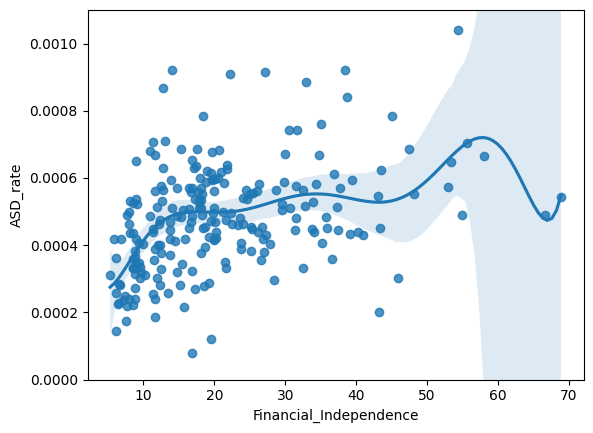

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.125
Method:                 Least Squares   F-statistic:                     6.368
Date:                Sun, 21 May 2023   Prob (F-statistic):           3.38e-06
Time:                        10:07:52   Log-Likelihood:                 1683.2
No. Observations:                 227   AIC:                            -3352.
Df Residuals:                     220   BIC:                            -3329.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.689e-09   5.01e-10     15.343      0.0

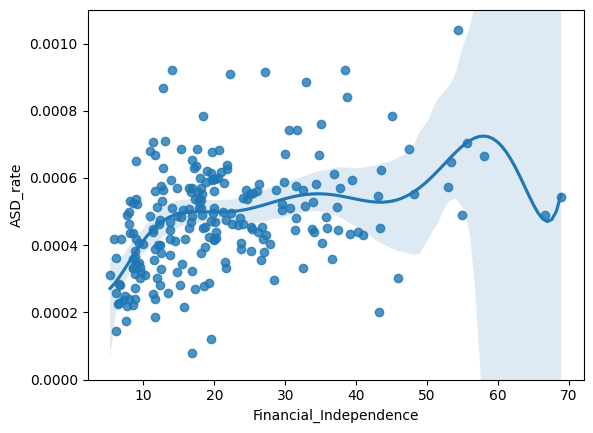

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                      -0.248
Model:                            OLS   Adj. R-squared:                 -0.282
Method:                 Least Squares   F-statistic:                    -7.282
Date:                Sun, 21 May 2023   Prob (F-statistic):               1.00
Time:                        10:07:52   Log-Likelihood:                 1639.9
No. Observations:                 227   AIC:                            -3266.
Df Residuals:                     220   BIC:                            -3242.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2.991e-11   1.95e-12     15.313      0.0

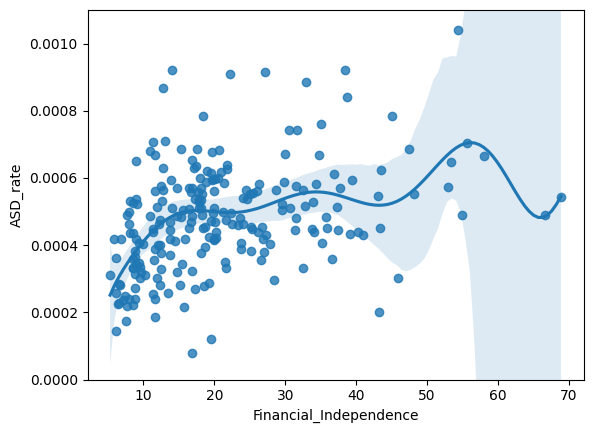

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                      -0.937
Model:                            OLS   Adj. R-squared:                 -0.990
Method:                 Least Squares   F-statistic:                    -17.74
Date:                Sun, 21 May 2023   Prob (F-statistic):               1.00
Time:                        10:07:53   Log-Likelihood:                 1590.0
No. Observations:                 227   AIC:                            -3166.
Df Residuals:                     220   BIC:                            -3142.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.157e-14    4.7e-15     13.112      0.0

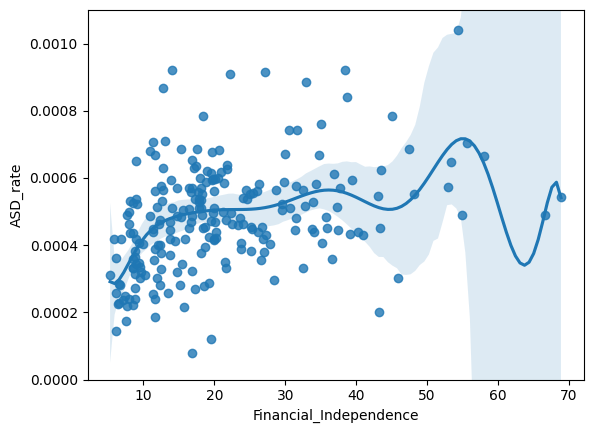

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                      -1.723
Model:                            OLS   Adj. R-squared:                 -1.785
Method:                 Least Squares   F-statistic:                    -27.97
Date:                Sun, 21 May 2023   Prob (F-statistic):               1.00
Time:                        10:07:54   Log-Likelihood:                 1551.4
No. Observations:                 227   AIC:                            -3091.
Df Residuals:                     221   BIC:                            -3070.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.328e-17    8.1e-18     11.522      0.0

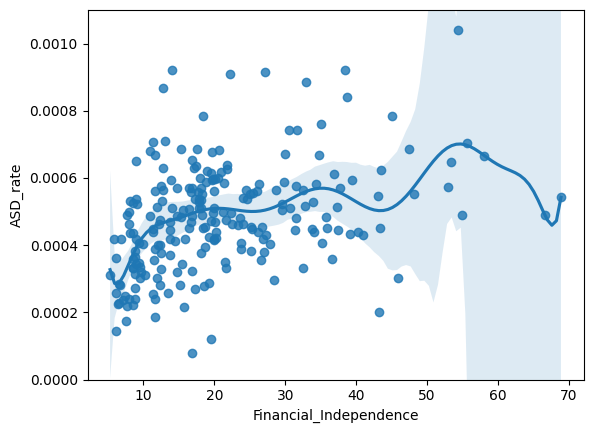

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                      -4.213
Model:                            OLS   Adj. R-squared:                 -4.331
Method:                 Least Squares   F-statistic:                    -35.72
Date:                Sun, 21 May 2023   Prob (F-statistic):               1.00
Time:                        10:07:54   Log-Likelihood:                 1477.6
No. Observations:                 227   AIC:                            -2943.
Df Residuals:                     221   BIC:                            -2923.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       9.147e-24    1.1e-24      8.311      0.0

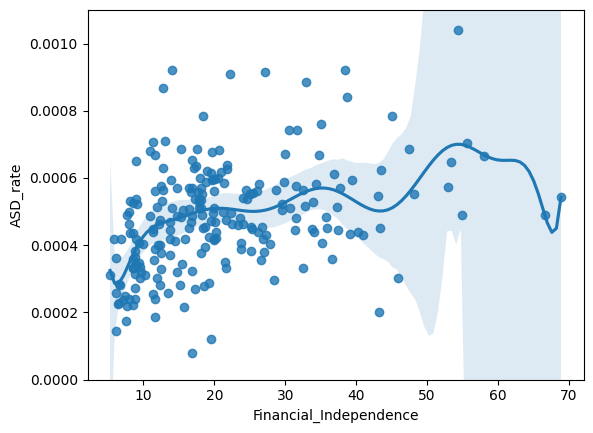

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                      -4.924
Model:                            OLS   Adj. R-squared:                 -5.058
Method:                 Least Squares   F-statistic:                    -36.74
Date:                Sun, 21 May 2023   Prob (F-statistic):               1.00
Time:                        10:07:55   Log-Likelihood:                 1463.2
No. Observations:                 227   AIC:                            -2914.
Df Residuals:                     221   BIC:                            -2894.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.575e-27   7.76e-28      7.188      0.0

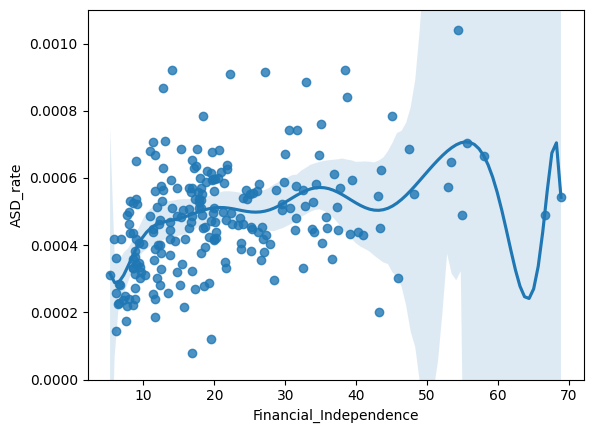

                            OLS Regression Results                            
Dep. Variable:               ASD_rate   R-squared:                      -5.468
Model:                            OLS   Adj. R-squared:                 -5.615
Method:                 Least Squares   F-statistic:                    -37.37
Date:                Sun, 21 May 2023   Prob (F-statistic):               1.00
Time:                        10:07:56   Log-Likelihood:                 1453.2
No. Observations:                 227   AIC:                            -2894.
Df Residuals:                     221   BIC:                            -2874.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.183e-30   4.93e-31      6.460      0.0

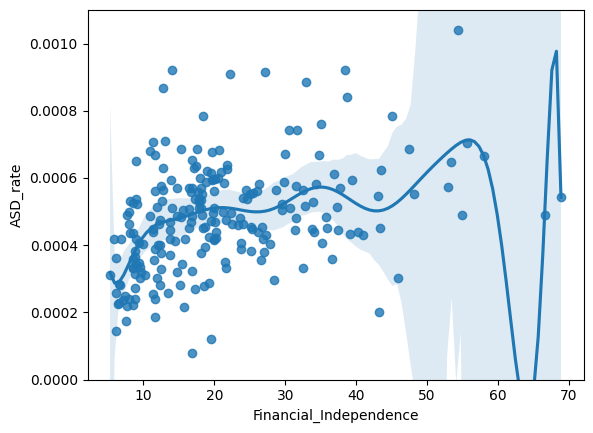

In [39]:
for i in range(0, 15):
    ASD_rate_for_X_train = Financial_Independence_polf[ : , 0: i + 1]
    ASD_rate_for_y_true = data['ASD_rate']

    ASD_rate_for_ols_sm = sm.OLS(ASD_rate_for_y_true, sm.add_constant(ASD_rate_for_X_train))

    ASD_rate_for_ols_sm_results = ASD_rate_for_ols_sm.fit()
    print(ASD_rate_for_ols_sm_results.summary())
    plt.ylim([0, 0.0011]) 
    sns.regplot(x='Financial_Independence', y='ASD_rate', data=data, order = i + 1)
    plt.show()

#seaborn overfitting error from 16

In [40]:
# More flexibility get Low MSE but meaningless and difficult to interpret
# And correlation is maintained despite the high flexibility.

## 4. BoostStrap

In [41]:
def boot_fn(data, start_index, end_index, X_val, y_val):
    m = LinearRegression(fit_intercept=True).fit(
        data[X_val].iloc[start_index:end_index].values.reshape(-1, 1),
        data[y_val].iloc[start_index:end_index]
    )
    
    return m.intercept_, m.coef_

boot_fn(data, 0, len(data), 'Financial_Independence', 'ASD_rate')

(0.00037832802857155494, array([4.87333138e-06]))

In [42]:
boot_fn(resample(data, replace=True, n_samples=len(data)), 0, len(data), 'Financial_Independence', 'ASD_rate')

(0.00039718948941927995, array([3.81600739e-06]))

t1 bs estimate & se 0.0003785930696225787 1.9791215993582738e-05
t2 bs estimate & se 4.8817209639947175e-06 8.966321551551753e-07


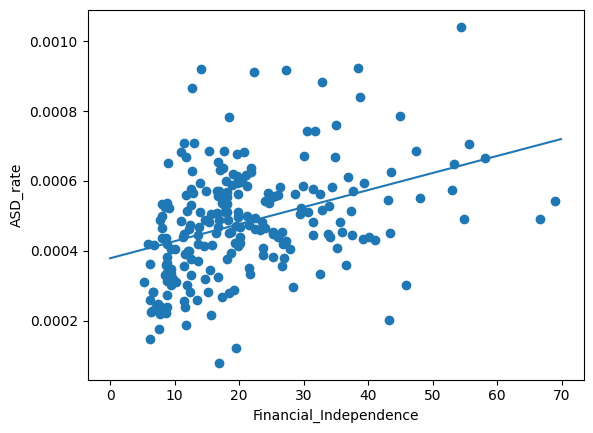

In [43]:
bs_boot = {'t1' : [], 't2':[]}

for i in range(0, 1000):
    bs_boot['t1'].append(
        boot_fn(resample(data, replace=True, n_samples=len(data)), 0, len(data), 'Financial_Independence', 'ASD_rate')[0]
    )
    bs_boot['t2'].append(
        boot_fn(resample(data, replace=True, n_samples=len(data)), 0, len(data), 'Financial_Independence', 'ASD_rate')[1][0]
    )
    
t1_es = np.array(bs_boot['t1']).mean()
t1_se = np.array(bs_boot['t1']).std()
t2_es = np.array(bs_boot['t2']).mean()
t2_se = np.array(bs_boot['t2']).std()

print('t1 bs estimate & se', t1_es, t1_se)
print('t2 bs estimate & se', t2_es, t2_se)

#Draw a graph (X=Financial_Independence(boot) Y=ASD_rate) with matplotlib
def predicBoot_function(x):
    return (t2_es*x + t1_es)
FI_Boot_x = np.arange(0, 70, 0.1)
FI_Boot_y = [predicBoot_function(x) for x in FI_Boot_x]
plt.scatter(data['Financial_Independence'], data['ASD_rate'])
plt.xlabel('Financial_Independence')
plt.ylabel('ASD_rate')
plt.plot(FI_Boot_x, FI_Boot_y)
plt.show()